# Downloads

In [49]:
!git clone https://github.com/dvschultz/stylegan2-ada-pytorch dvschultz-stylegan2-ada-pytorch

Cloning into 'dvschultz-stylegan2-ada-pytorch'...
remote: Enumerating objects: 524, done.
remote: Total 524 (delta 0), reused 0 (delta 0), pack-reused 524
Receiving objects: 100% (524/524), 8.40 MiB | 17.60 MiB/s, done.
Resolving deltas: 100% (298/298), done.


In [ ]:
%cd dvschultz-stylegan2-ada-pytorch/

In [51]:
# Cluster files
!gdown --id 17eGxxtT_DdKD4WotgJfXf8IGA9_cXAiH
!unzip StyleGAN2_Genre_Clustering-20210719T132300Z-001.zip 

Downloading...
From: https://drive.google.com/uc?id=17eGxxtT_DdKD4WotgJfXf8IGA9_cXAiH
To: /home/app/application/ML/ml-server-example/sg2ada-pytorch/dvschultz-stylegan2-ada-pytorch/StyleGAN2_Genre_Clustering-20210719T132300Z-001.zip
610MB [00:09, 64.2MB/s] 
Archive:  StyleGAN2_Genre_Clustering-20210719T132300Z-001.zip
  inflating: StyleGAN2_Genre_Clustering/flowers_cluster_avg_64_64k.npy  
  inflating: StyleGAN2_Genre_Clustering/flowers_cluster_labels_64_64k.npy  
  inflating: StyleGAN2_Genre_Clustering/flowers_pca_model_64k.pkl  
  inflating: StyleGAN2_Genre_Clustering/flowers_gmm_model_64_64k.pkl  
  inflating: StyleGAN2_Genre_Clustering/flowers_ica_model_64k.pkl  
  inflating: StyleGAN2_Genre_Clustering/flowers_clip_64k_1.npy  
  inflating: StyleGAN2_Genre_Clustering/flowers_clip_64k_2.npy  
  inflating: StyleGAN2_Genre_Clustering/flowers_latents_64k.npy  
  inflating: StyleGAN2_Genre_Clustering/flowers_all_features_64k.npy  


In [52]:
# Model
!gdown --id 14896oHvNWYsxQvbrJiah8H9srown10wW
!mv network-snapshot-000192.pkl stylegan2-ada-pytorch

Downloading...
From: https://drive.google.com/uc?id=14896oHvNWYsxQvbrJiah8H9srown10wW
To: /home/app/application/ML/ml-server-example/sg2ada-pytorch/dvschultz-stylegan2-ada-pytorch/network-snapshot-000192.pkl
382MB [00:04, 88.9MB/s] 


# 🏁 Start

In [175]:
!nvidia-smi -L

GPU 0: NVIDIA Quadro P4000 (UUID: GPU-86e36a54-af11-404e-c3ed-9b94909e133e)
GPU 1: NVIDIA Quadro P4000 (UUID: GPU-eb6455f3-3751-3d5a-fbc5-1c8e2df99d22)


In [176]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Mar_21_19:15:46_PDT_2021
Cuda compilation tools, release 11.3, V11.3.58
Build cuda_11.3.r11.3/compiler.29745058_0


In [177]:
%cd dvschultz-stylegan2-ada-pytorch/

[Errno 2] No such file or directory: 'dvschultz-stylegan2-ada-pytorch/'
/home/app/application/ML/ml-server-example/sg2ada-pytorch/dvschultz-stylegan2-ada-pytorch


In [185]:
import os
import numpy as np
import torch
import pickle
import PIL.Image
from tqdm.autonotebook import tqdm
import torch.nn.functional as F
import dnnlib
import legacy
import imageio
from IPython.display import Video

In [179]:
folder = 'StyleGAN2_Genre_Clustering'
prefix = 'flowers_v3'
suffix = '64cat_65536s_123seed_1psi_const'
ws = np.load(f"{folder}/{prefix}_latents_ws_{suffix}.npy")
zs = np.load(f"{folder}/{prefix}_latents_zs_{suffix}.npy")
cluster_avg = np.load(f"{folder}/{prefix}_cluster_avg_{suffix}.npy")
cluster_labels = np.load(f"{folder}/{prefix}_cluster_labels_{suffix}.npy")
print(ws.shape, zs.shape, cluster_avg.shape, cluster_labels.shape)

(65536, 512) (65536, 512) (64, 512) (65536,)


In [180]:
outdir = f'{folder}/clusters'
# Numbe of image to render per cluster
img_count = 4
clusters_count = cluster_labels.max()
network_pkl = 'network-snapshot-000192.pkl'
truncation_psi = 1
noise_mode = 'const' # 'const', 'random', 'none'

device_00 = torch.device('cuda:0')
device_01 = torch.device('cuda:1')
image_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).to(device_00)
image_std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).to(device_00)

In [181]:
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device_01) # type: ignore

In [182]:
def make_movie(fn, imgs, fps):
    with imageio.get_writer(fn, format='FFMPEG', codec='h264', fps=fps) as w:
        for img in imgs:
            w.append_data(np.array(img))


def zs_to_ws(G, zs, labels, truncation_psi=1, truncation_cutoff=None):
    ws = G.mapping(zs, labels, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
    return ws


# noise_mode = 'const', 'random', 'none'
def generate_images_from_zs(G, latents, labels, batch_size, truncation_psi=1, noise_mode='const', truncation_cutoff=None):
    all_imgs = []
    for i in tqdm(range(latents.shape[0]//batch_size)):
        zs = latents[i*batch_size:(i+1)*batch_size, :]        
        imgs = G(zs, labels, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff, noise_mode=noise_mode)
        imgs = (imgs.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        for j in range(imgs.shape[0]):
            img = imgs[j].cpu().numpy()
            all_imgs.append(PIL.Image.fromarray(img, 'RGB'))
    return all_imgs


# noise_mode = 'const', 'random', 'none'
def generate_images_from_ws(G, latents, batch_size, truncation_psi=1, noise_mode='const'):
    all_imgs = []
    for i in tqdm(range(latents.shape[0]//batch_size)):
        ws = latents[i*batch_size:(i+1)*batch_size, :]
        w_avg = G.mapping.w_avg
        ws = w_avg + (ws - w_avg) * truncation_psi
        imgs = G.synthesis(ws, noise_mode=noise_mode)
        imgs = (imgs.clamp(-1, 1).permute(0, 2, 3, 1).cpu().numpy() * 127.5 + 128).astype(np.uint8)
        for j in range(imgs.shape[0]):
            all_imgs.append(PIL.Image.fromarray(imgs[j]))
    return all_imgs


def image_grid(images, rows, cols):
    assert len(images) == rows*cols
    print(images[0])
    w, h = images[0].size
    grid = PIL.Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(images):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid


def circular_interpolation(radius, lats_persistent, lats_interpolate):
    lats_a, lats_b, lats_c = lats_persistent

    lats_axis_x = (lats_a - lats_b).flatten() / np.linalg.norm(lats_a - lats_b)
    lats_axis_y = (lats_a - lats_c).flatten() / np.linalg.norm(lats_a - lats_c)

    lats_x = np.sin(np.pi * 2.0 * lats_interpolate) * radius
    lats_y = np.cos(np.pi * 2.0 * lats_interpolate) * radius - radius
    
    latents = lats_a + lats_x * lats_axis_x + lats_y * lats_axis_y
    return latents


def lisajou_interpolation(radius, lats_persistent, a, b, c, lats_interpolate):
    lats_a, lats_b, lats_c, lats_d = lats_persistent

    lats_axis_x = (lats_a - lats_b).flatten() / np.linalg.norm(lats_a - lats_b)
    lats_axis_y = (lats_a - lats_c).flatten() / np.linalg.norm(lats_a - lats_c)
    lats_axis_z = (lats_a - lats_d).flatten() / np.linalg.norm(lats_a - lats_d)

    lats_x = np.sin(np.pi * 2.0 * lats_interpolate * a) * radius
    lats_y = np.sin(np.pi * 2.0 * lats_interpolate * b) * radius
    lats_z = np.sin(np.pi * 2.0 * lats_interpolate * c) * radius
    
    latents = np.copy(lats_a)
    latents[0, 0::3] += lats_x * lats_axis_x[::3]
    latents[0, 1::3] += lats_y * lats_axis_x[1::3]
    latents[0, 2::3] += lats_z * lats_axis_z[2::3]
    
    return latents

# slightly modified version of
# https://github.com/PDillis/stylegan2-fun/blob/master/run_generator.py#L399
def slerp(t, v0, v1, DOT_THRESHOLD=0.9995):
    '''
    Spherical linear interpolation
    Args:
        t (float/np.ndarray): Float value between 0.0 and 1.0
        v0 (np.ndarray): Starting vector
        v1 (np.ndarray): Final vector
        DOT_THRESHOLD (float): Threshold for considering the two vectors as
                               colineal. Not recommended to alter this.
    Returns:
        v2 (np.ndarray): Interpolation vector between v0 and v1
    '''
    # Copy the vectors to reuse them later
    v0_copy = np.copy(v0)
    v1_copy = np.copy(v1)
    # Normalize the vectors to get the directions and angles
    v0 = v0 / np.linalg.norm(v0)
    v1 = v1 / np.linalg.norm(v1)
    # Dot product with the normalized vectors (can't use np.dot in W)
    dot = np.sum(v0 * v1)
    # If absolute value of dot product is almost 1, vectors are ~colineal, so use lerp
    if np.abs(dot) > DOT_THRESHOLD:
        return lerp(t, v0_copy, v1_copy)
    # Calculate initial angle between v0 and v1
    theta_0 = np.arccos(dot)
    sin_theta_0 = np.sin(theta_0)
    # Angle at timestep t
    theta_t = theta_0 * t
    sin_theta_t = np.sin(theta_t)
    # Finish the slerp algorithm
    s0 = np.sin(theta_0 - theta_t) / sin_theta_0
    s1 = sin_theta_t / sin_theta_0
    v2 = s0 * v0_copy + s1 * v1_copy
    return v2


In [183]:
# Convert ws and zs to tensors
if isinstance(ws, np.ndarray):
    ws = np.expand_dims(ws, axis=1)
    ws = np.tile(ws, [1, G.mapping.num_ws, 1])
    ws = torch.tensor(ws, dtype=torch.float32, device=device_00)
if isinstance(zs, np.ndarray):
    zs = torch.tensor(zs, dtype=torch.float32, device=device_00)

In [165]:
frame_count = 576//4
batch_size = 16
start = 0.5
random_seeds = np.random.randint(0, 1000, 3)
radius = 8
fps = 24

In [166]:
a_z = np.load(f'{outdir}/0/1_z.npz')['z']
b_z = a_z + (np.random.RandomState(random_seeds[0]).randn(1, 512)-.5)
c_z = a_z + (np.random.RandomState(random_seeds[1]).randn(1, 512)-.5)
d_z = a_z + (np.random.RandomState(random_seeds[2]).randn(1, 512)-.5)

In [167]:
zs = [circular_interpolation(radius, (a_z, b_z, c_z), start+(i/frame_count)*(1-start)) for i in range(frame_count)]

zs = np.array(zs)[:,0,:]
zs = torch.from_numpy(zs).to(device_01)
labels = torch.zeros([zs.shape[0], G.c_dim], device=device_01)

imgs = generate_images_from_zs(G, zs, labels, batch_size, truncation_psi)

fn = f"circular_start_{str(start).replace('.', ',')}_radius_{radius}_random-seeds{random_seeds.tolist()}.mp4"
make_movie(fn, imgs, fps)

  0%|          | 0/9 [00:00<?, ?it/s]

In [169]:
zs = [lisajou_interpolation(radius, (a_z, b_z, c_z, d_z), 1, 2, 2, start+(i/frame_count)*(1-start)) for i in range(frame_count)]

zs = np.array(zs)[:,0,:]
zs = torch.from_numpy(zs).to(device_01)
labels = torch.zeros([zs.shape[0], G.c_dim], device=device_01)

imgs = generate_images_from_zs(G, zs, labels, batch_size, truncation_psi)

fn = f"lisajou_start_{str(start).replace('.', ',')}_radius_{radius}_random-seeds{random_seeds.tolist()}.mp4"
make_movie(fn, imgs, fps)

  0%|          | 0/9 [00:00<?, ?it/s]

In [170]:
zs = [slerp(start+(i/frame_count)*(1-start), b_z, a_z) for i in range(frame_count)]

zs = np.array(zs)[:,0,:]
zs = torch.from_numpy(zs).to(device_01)
labels = torch.zeros([zs.shape[0], G.c_dim], device=device_01)

imgs = generate_images_from_zs(G, zs, labels, batch_size, truncation_psi)

fn = f"slerp_start_{str(start).replace('.', ',')}_random-seeds{random_seeds[0]}.mp4"
make_movie(fn, imgs, fps)

  0%|          | 0/9 [00:00<?, ?it/s]

In [171]:
Video(fn, embed=True, width=800, height=800)

In [196]:
# Generate
all_imgs = []

for i in range(2):

    # Mask latents array using cluster_labels
    ws_cluster = ws[cluster_labels==i].to(device_01)
    zs_cluster = zs[cluster_labels==i].to(device_01)
    
    print(f'Cluster {i}: {ws_cluster.shape[0]} imgs (saving {img_count}, trunc_psi:{truncation_psi}, noise_mode:{noise_mode})')
    imgs = generate_images_from_ws(G, ws_cluster[:img_count], 4, truncation_psi, noise_mode)
    all_imgs.append(imgs)

    # Save imgs + npz + vids
    os.makedirs(f'{outdir}/{i}', exist_ok=True)
    
    for j, (img, w, z) in enumerate(zip(imgs, ws_cluster, zs_cluster)):
        
        print(f'->Saving {outdir}/{i}/{j}')
        
        fn = f"{j}_{str(truncation_psi).replace('.', ',')}psi_{noise_mode}"
        img.save(f"{outdir}/{i}/{fn}.jpg")
        np.savez(f'{outdir}/{i}/{j}_w.npz', w=w.unsqueeze(0).cpu().numpy())
        np.savez(f'{outdir}/{i}/{j}_z.npz', z=z.unsqueeze(0).cpu().numpy())
        
        frame_count = 576//4
        batch_size = 16
        start = 0.5
        random_seeds = np.random.randint(0, 1000, 3)
        radius = 8
        fps = 24
        
        z = z.unsqueeze(0).cpu().numpy()
        z1 = z + (np.random.RandomState(random_seeds[0]).randn(1, 512)-.5)
        z2 = z + (np.random.RandomState(random_seeds[1]).randn(1, 512)-.5)
        z3 = z + (np.random.RandomState(random_seeds[2]).randn(1, 512)-.5)
        circular_zs = [circular_interpolation(radius, (z, z1, z2), start+(i/frame_count)*(1-start)) for i in range(frame_count)]

        circular_zs = torch.from_numpy(np.array(circular_zs)[:,0,:]).to(device_01)
        labels = torch.zeros([circular_zs.shape[0], G.c_dim], device=device_01)

        imgs = generate_images_from_zs(G, circular_zs, labels, batch_size, truncation_psi)

        fn += f"_circular_start_{str(start).replace('.', ',')}_radius_{radius}_random-seeds{random_seeds[:2].tolist()}"
        make_movie(f"{outdir}/{i}/{fn}.mp4", imgs, fps)

Cluster 0: 1639 imgs (saving 4, trunc_psi:1, noise_mode:const)


  0%|          | 0/1 [00:00<?, ?it/s]

->Saving StyleGAN2_Genre_Clustering/clusters/0/0
(1, 512)


  0%|          | 0/9 [00:00<?, ?it/s]

->Saving StyleGAN2_Genre_Clustering/clusters/0/1
(1, 512)


  0%|          | 0/9 [00:00<?, ?it/s]

->Saving StyleGAN2_Genre_Clustering/clusters/0/2
(1, 512)


  0%|          | 0/9 [00:00<?, ?it/s]

->Saving StyleGAN2_Genre_Clustering/clusters/0/3
(1, 512)


  0%|          | 0/9 [00:00<?, ?it/s]

Cluster 1: 963 imgs (saving 4, trunc_psi:1, noise_mode:const)


  0%|          | 0/1 [00:00<?, ?it/s]

->Saving StyleGAN2_Genre_Clustering/clusters/1/0
(1, 512)


  0%|          | 0/9 [00:00<?, ?it/s]

->Saving StyleGAN2_Genre_Clustering/clusters/1/1
(1, 512)


  0%|          | 0/9 [00:00<?, ?it/s]

->Saving StyleGAN2_Genre_Clustering/clusters/1/2
(1, 512)


  0%|          | 0/9 [00:00<?, ?it/s]

->Saving StyleGAN2_Genre_Clustering/clusters/1/3
(1, 512)


  0%|          | 0/9 [00:00<?, ?it/s]

In [16]:
# Truncation
a_z = np.load(f'{outdir}/0/5_z.npz')['z']
a_z = torch.from_numpy(a_z).to(device_01)
labels = torch.zeros([a_z.shape[0], G.c_dim], device=device_01)

lats = [zs_to_ws(G, a_z, labels, (i/fc)+.5).cpu().numpy() for i in range(fc)]
lats = np.array(lats)[:,0,:]
lats = torch.from_numpy(lats).to(device_01)

imgs = generate_images_from_ws(G, lats, bs)

  0%|          | 0/72 [00:00<?, ?it/s]

torch.Size([1, 18, 512]) torch.Size([1, 18, 512])


  0%|          | 0/1 [00:00<?, ?it/s]

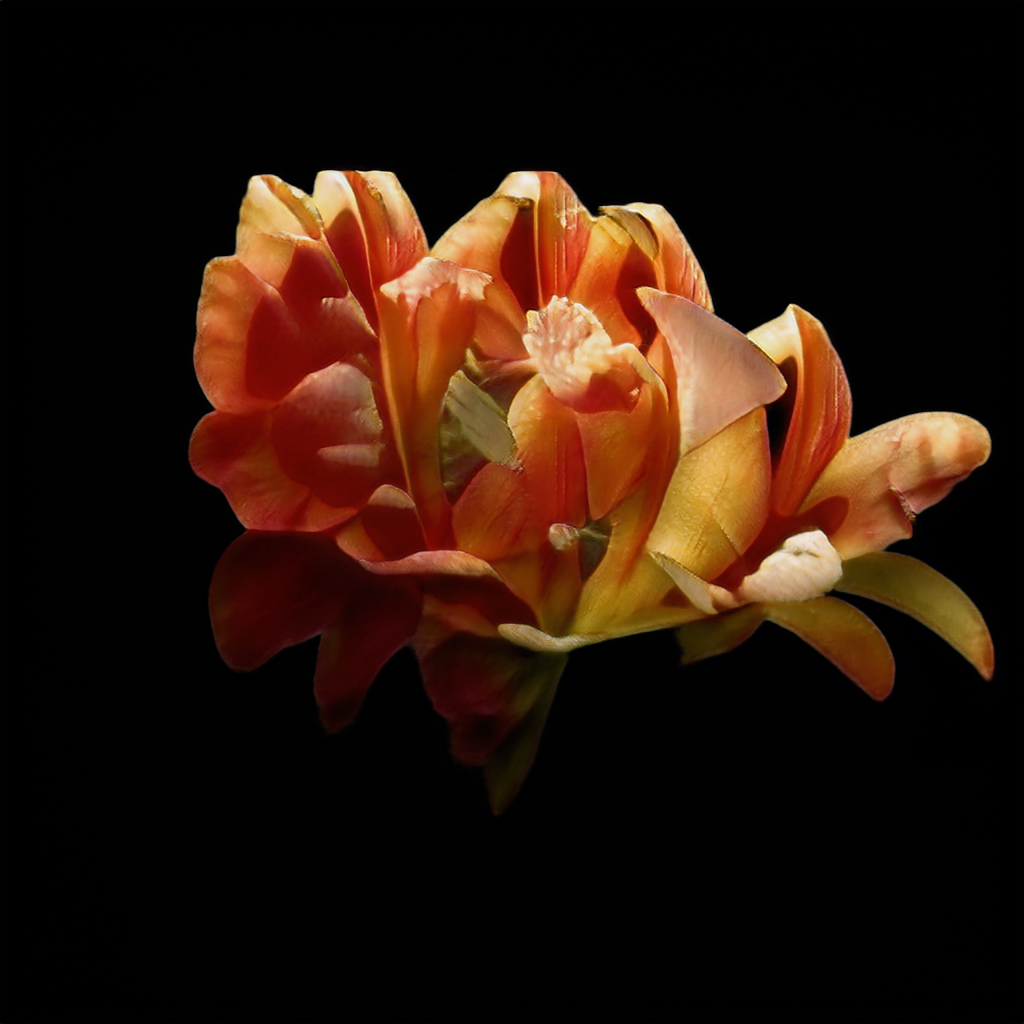

In [34]:
# Style Mixing
# a_w = torch.from_numpy(np.load(f'{outdir}/0/0_w.npz')['w']).to(device_01)
a_z = torch.from_numpy(np.load(f'{outdir}/style_transfer_seeds/seed0297.npy')).to(device_01)
a_w = G.mapping(a_z, None)

b_w = torch.from_numpy(np.load(f'{outdir}/0/6_w.npz')['w']).to(device_01)

w = a_w.clone()
w[0][[1,2,3,4,5,6,7,8]] = b_w[0][[1,2,3,4,5,6,7,8]]

imgs = generate_images_from_ws(G, w, 1, .5)
display(imgs[0])

---

In [40]:
# TESTS
# l = np.load(f'{outdir}/0/1_z.npz')['z']
# l = np.array([[1,2,3,4], [2,3,4,6]])
# a = np.random.randint(5, size=(4,512))
a = np.ones((4,512))
l = np.zeros((4,512))
# print(l[:, ::2].shape)
# l[:, ::2] = 10
# l[:, 1::2] = 100
# l[:, 2::3] = 1000

# x = np.array([1,2,3])
# x = np.tile(x, 512//x.shape[0]+1)
# x = np.delete(x, 512-x.shape[0])
# l[:,0::3] -= x[0::3]
# l[:,1::3] += x[1::3]
# l[:,2::3] -= x[2::3]
# print(l.shape, l[:,:10])
a[[1,2,3]].shape

(3, 512)

In [71]:
!python combine_npz.py --outdir={outdir}/npz --npzs='{outdir}/0/0_w.npz,{outdir}/0/1_w.npz,{outdir}/0/2_w.npz'

Combining .npz files...
StyleGAN2_Genre_Clustering/clusters/0/0_w.npz
StyleGAN2_Genre_Clustering/clusters/0/1_w.npz
StyleGAN2_Genre_Clustering/clusters/0/2_w.npz
torch.Size([3, 18, 512])


In [11]:
!python generate.py \
    --process=interpolation \
    --interpolation=linear \
    --easing=easeInOutQuad \
    --space=w \
    --network={network_pkl} \
    --outdir={outdir}/combined-proj/ \
    --projected-w={outdir}/npz/combined.npz \
    --frames=120

/home/app/application/ML/ml-server-example/sg2ada-pytorch/dvschultz-stylegan2-ada-pytorch/generate.py:59: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  elif(len(seeds) is not 3):
Loading networks from "network-snapshot-000192.pkl"...
Generating image for frame 0/240 ...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
Generating image for frame 1/240 ...
Generating image for frame 2/240 ...
Generating image for frame 3/240 ...
Generating image for frame 4/240 ...
Generating image for frame 5/240 ...
Generating image for frame 6/240 ...
Generating image for frame 7/240 ...
Generating image for frame 8/240 ...
Generating image for frame 9/240 ...
Generating image for frame 10/240 ...
Generating image for frame 11/240 ...
Generating image for frame 12/240 ...
Generating image for frame 13/240 ...
Generating image for frame 14/240 ...
Generating image for frame 15/240 ...
Generating image for frame 16/240 ...
Generati

Generating image for frame 204/240 ...
Generating image for frame 205/240 ...
Generating image for frame 206/240 ...
Generating image for frame 207/240 ...
Generating image for frame 208/240 ...
Generating image for frame 209/240 ...
Generating image for frame 210/240 ...
Generating image for frame 211/240 ...
Generating image for frame 212/240 ...
Generating image for frame 213/240 ...
Generating image for frame 214/240 ...
Generating image for frame 215/240 ...
Generating image for frame 216/240 ...
Generating image for frame 217/240 ...
Generating image for frame 218/240 ...
Generating image for frame 219/240 ...
Generating image for frame 220/240 ...
Generating image for frame 221/240 ...
Generating image for frame 222/240 ...
Generating image for frame 223/240 ...
Generating image for frame 224/240 ...
Generating image for frame 225/240 ...
Generating image for frame 226/240 ...
Generating image for frame 227/240 ...
Generating image for frame 228/240 ...
Generating image for fram

In [ ]:
!python generate.py \
    --outdir={outdir}/video-circularloop/ \
    --trunc=1 \
    --process="interpolation" \
    --interpolation="circularloop" \
    --diameter=800.00 \
    --frames=720 \
    --random_seed=90 --network=/content/stylegan2-ada-pytorch/pretrained/wikiart.pkl

In [ ]:
# Generate from Zs
# Convert back from np to Torch
if isinstance(zs, np.ndarray):
    zs = torch.tensor(zs, dtype=torch.float32, device=device)
labels = torch.zeros([zs.shape[0], G.c_dim], device=device)
all_imgs_from_zs = []
for i in range(2):
    # Mask latents array using cluster_labels
    zs_cluster = zs[cluster_labels==i]
    print(zs_cluster.shape)
    print(f'Cluster {i}: {zs_cluster.shape[0]} imgs (saving {img_count}, trunc_psi:{truncation_psi}, noise_mode:{noise_mode})')
    # Convert back from np to Torch
    imgs = generate_images_from_zs(G, device, zs_cluster[:img_count], labels[:img_count], 16, truncation_psi, noise_mode)
    all_imgs_from_zs.append(imgs)

In [ ]:
for imgs in all_imgs_from_zs:
    display(image_grid(imgs, 4, 4))

In [13]:
# Clear GPU mem
with torch.no_grad():
    torch.cuda.empty_cache()